1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import os
from scipy.stats import chisquare  # Исправленный импорт

def F_inv(u):
    """
    Обратная функция распределения (метод инверсии).
    F(x) = {
      x^2,                      x in [0, 0.5],
      1.5*x - 0.5,             x in (0.5, 1].
    }
    F_inv(u) = ?
    
    Для 0 <= u <= 0.25:  X = sqrt(u),  т.к. F(x)=x^2
    Для 0.25 < u <= 1:   X = (u + 0.5)/1.5
    """
    return np.where(u <= 0.25, np.sqrt(u), (u + 0.5) / 1.5)

def generate_sample(n=5000, random_seed=42):
    """
    Генерация выборки из n случайных величин с заданным распределением.
    
    Параметры:
    - n: размер выборки
    - random_seed: начальное значение для генератора случайных чисел
    
    Возвращает:
    - X: массив сгенерированных случайных величин
    """
    np.random.seed(random_seed)
    U = np.random.rand(n)  # U ~ Uniform(0,1)
    X = F_inv(U)
    return X

def plot_histogram(X, filepath, bins='auto'):
    """
    Построение и сохранение гистограммы выборки.
    
    Параметры:
    - X: массив случайных величин
    - filepath: путь для сохранения графика
    - bins: количество бинов или метод их определения
    """
    plt.figure(figsize=(10,6))
    plt.hist(X, bins=bins, density=True, alpha=0.6, edgecolor='black', color='skyblue', label='Эмпирическое распределение')
    
    # Теоретическая функция плотности
    x_vals = np.linspace(0, 1, 400)
    f_x = np.where(x_vals <= 0.5, 2*x_vals, 1.5*np.ones_like(x_vals))
    plt.plot(x_vals, f_x, 'r-', label='Теоретическая плотность')
    
    plt.title("Гистограмма выборки")
    plt.xlabel("Значение")
    plt.ylabel("Относительная частота")
    plt.legend()
    plt.grid(True)
    plt.savefig(filepath)
    plt.close()
    print(f"Гистограмма сохранена в {filepath}")

def random_walk_trajectories(X, filepath, num_trajectories=3, steps_per_trajectory=100):
    """
    Генерация и сохранение графика траекторий симметричного случайного блуждания.
    
    Параметры:
    - X: массив случайных величин
    - filepath: путь для сохранения графика
    - num_trajectories: количество траекторий для построения
    - steps_per_trajectory: количество шагов в каждой траектории
    """
    plt.figure(figsize=(12, 8))
    
    index = 0
    for i in range(num_trajectories):
        # Берём отрезок X[index : index+steps_per_trajectory]
        steps = X[index : index + steps_per_trajectory]
        index += steps_per_trajectory
        
        # Симметричное случайное блуждание: шаг может быть +1 или -1
        directions = np.where(steps < 0.5, -1, 1)  # Например, если X < 0.5, шаг -1, иначе +1
        rw = np.cumsum(directions)
        plt.plot(rw, label=f"Траектория {i+1}")
        
    plt.title("Симметричные случайные блуждания")
    plt.xlabel("Номер шага")
    plt.ylabel("Положение блуждания")
    plt.legend()
    plt.grid(True)
    plt.savefig(filepath)
    plt.close()
    print(f"Траектории случайного блуждания сохранены в {filepath}")

def compute_theoretical_moments():
    """
    Вычисление теоретических математического ожидания и дисперсии.
    
    Возвращает:
    - E: математическое ожидание
    - Var: дисперсия
    """
    # Для x в [0,0.5]: f(x) = 2x
    # Для x в (0.5,1]: f(x) = 1.5
    # E(X) = ∫0^0.5 x*2x dx + ∫0.5^1 x*1.5 dx = 2∫0^0.5 x^2 dx + 1.5∫0.5^1 x dx
    E = 2 * ( (0.5**3) / 3 ) + 1.5 * ( (1**2)/2 - (0.5**2)/2 )
    # E(X^2) = ∫0^0.5 x^2*2x dx + ∫0.5^1 x^2*1.5 dx = 2∫0^0.5 x^3 dx + 1.5∫0.5^1 x^2 dx
    E_x2 = 2 * ( (0.5**4) / 4 ) + 1.5 * ( (1**3)/3 - (0.5**3)/3 )
    Var = E_x2 - E**2
    return E, Var

def sample_moments_for_subsamples(X, filepath, step=200, max_k=25):
    """
    Вычисление выборочных моментов и сохранение графиков относительной погрешности.
    
    Параметры:
    - X: массив случайных величин
    - filepath: путь для сохранения графика
    - step: шаг увеличения размера выборки
    - max_k: максимальный множитель шага
    """
    E_th, Var_th = compute_theoretical_moments()
    ns = []
    mean_errors = []
    var_errors = []
    
    for k in range(1, max_k+1):
        n = step * k
        if n > len(X):
            print(f"Пропуск n={n}, так как превышает размер выборки.")
            continue
        sample_subset = X[:n]
        mean_ = np.mean(sample_subset)
        var_ = np.var(sample_subset, ddof=1)  # Несмещённая дисперсия
        
        mean_error = abs(mean_ - E_th) / abs(E_th)
        var_error  = abs(var_ - Var_th) / abs(Var_th)
        
        ns.append(n)
        mean_errors.append(mean_error)
        var_errors.append(var_error)
    
    # Создание директории для графиков, если не существует
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # График относительной погрешности для средних
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(ns, mean_errors, marker='o', color='blue')
    plt.title("Относительная погрешность для E(X)")
    plt.xlabel("Размер выборки (n)")
    plt.ylabel("Погрешность")
    plt.grid(True)
    
    # График относительной погрешности для дисперсий
    plt.subplot(1, 2, 2)
    plt.plot(ns, var_errors, marker='o', color='red')
    plt.title("Относительная погрешность для Var(X)")
    plt.xlabel("Размер выборки (n)")
    plt.ylabel("Погрешность")
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()
    print(f"Графики погрешности моментов сохранены в {filepath}")

def chi_square_test(X, filepath, bins=10):
    """
    Проведение теста согласия \(\chi^2\) между эмпирическим распределением выборки и теоретическим.
    Результаты сохраняются в текстовый файл.
    
    Параметры:
    - X: массив случайных величин
    - filepath: путь для сохранения результатов теста
    - bins: количество интервалов для гистограммы
    """
    # Разбиваем [0,1] на интервалы:
    edges = np.linspace(0, 1, bins+1)
    observed, _ = np.histogram(X, bins=edges)
    
    # Теоретическая функция распределения
    def F(x):
        if x < 0: 
            return 0
        elif x <= 0.5: 
            return x**2
        elif x <= 1: 
            return 1.5*x - 0.5
        else:
            return 1
    
    # Вычисление теоретических вероятностей для каждого интервала
    p = []
    for i in range(bins):
        left = edges[i]
        right = edges[i+1]
        p_i = F(right) - F(left)
        p.append(p_i)
    p = np.array(p)
    
    # Проверка, чтобы все p_i >= 0.05 для надежности \(\chi^2\) теста
    # Если нет, объединим малые бинны с соседними
    min_expected = 5  # Минимальное ожидаемое число событий
    expected = p * len(X)
    
    while True:
        small_bins = expected < min_expected
        if not small_bins.any():
            break
        # Объединяем малые бинны с соседним
        first_small = np.where(small_bins)[0][0]
        if first_small == 0:
            # Объединяем с правым
            p[first_small+1] += p[first_small]
            observed[first_small+1] += observed[first_small]
        else:
            # Объединяем с левым
            p[first_small-1] += p[first_small]
            observed[first_small-1] += observed[first_small]
        # Удаляем объединённый бин
        p = np.delete(p, first_small)
        observed = np.delete(observed, first_small)
        expected = p * len(X)
    
    # Проведение \(\chi^2\) теста
    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
    
    # Сохранение результатов теста в файл с указанием кодировки utf-8
    with open(filepath, "w", encoding='utf-8') as f:
        f.write("Тест согласия χ²\n")
        f.write(f"Число интервалов после объединения: {len(observed)}\n")
        f.write(f"Статистика χ²: {chi2_stat:.4f}\n")
        f.write(f"p-value: {p_value:.4f}\n")
    
    print(f"Результаты теста χ² сохранены в {filepath}")
    return chi2_stat, p_value

def main():
    # Создание директории для графиков, если не существует
    os.makedirs("charts", exist_ok=True)
    
    # 1) Генерация выборки
    X = generate_sample(n=5000, random_seed=42)
    
    # 2) Построение и сохранение гистограммы
    plot_histogram(X, filepath="charts/task1_histogram.png", bins=30)
    
    # 3) Построение и сохранение траекторий случайного блуждания
    random_walk_trajectories(X, filepath="charts/task1_random_walk_trajectories.png", 
                             num_trajectories=3, steps_per_trajectory=100)
    
    # 4) Вычисление теоретических и выборочных моментов
    E_th, Var_th = compute_theoretical_moments()
    E_sample = np.mean(X)
    Var_sample = np.var(X, ddof=1)
    print(f"Теоретическое математическое ожидание: {E_th:.5f}")
    print(f"Теоретическая дисперсия: {Var_th:.5f}")
    print(f"Выборочное среднее: {E_sample:.5f}")
    print(f"Выборочная дисперсия: {Var_sample:.5f}")
    
    # 5) Построение и сохранение графиков относительной погрешности
    sample_moments_for_subsamples(X, filepath="charts/task1_moments_error.png", 
                                  step=200, max_k=25)
    
    # 6) Проведение теста χ² и сохранение результатов
    chi2_stat, p_value = chi_square_test(X, filepath="charts/task1_chi_square_test.txt", bins=10)
    print(f"\nРезультаты теста χ²:")
    print(f"Статистика χ²: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

if __name__ == "__main__":
    main()

Гистограмма сохранена в charts/task1_histogram.png
Траектории случайного блуждания сохранены в charts/task1_random_walk_trajectories.png
Теоретическое математическое ожидание: 0.64583
Теоретическая дисперсия: 0.05165
Выборочное среднее: 0.64304
Выборочная дисперсия: 0.05224
Графики погрешности моментов сохранены в charts/task1_moments_error.png
Результаты теста χ² сохранены в charts/task1_chi_square_test.txt

Результаты теста χ²:
Статистика χ²: 9.8211
p-value: 0.3652


2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import os
from scipy.stats import chisquare
from scipy.linalg import fractional_matrix_power

def step_markov_chain(P, p0, steps=1):
    """
    Делает один (или несколько) шагов марковской цепи.
    P  - матрица переходов (size = (m, m))
    p0 - вектор распределения (size = (m,))
    """
    p_current = p0
    for _ in range(steps):
        p_current = p_current @ P
    return p_current

def simulate_one_trajectory(P, p0, length=1000, random_seed=42):
    """
    Генерация одной траектории длины length.
    """
    np.random.seed(random_seed)
    m = P.shape[0]
    states = []
    initial_state = np.random.choice(np.arange(m), p=p0)
    states.append(initial_state)
    
    for _ in range(1, length):
        current_state = states[-1]
        next_state = np.random.choice(np.arange(m), p=P[current_state])
        states.append(next_state)
    
    return np.array(states)

def estimate_transition_matrix(trajectory, m):
    """
    Оцениваем матрицу перехода по одной траектории.
    """
    count_matrix = np.zeros((m, m))
    
    for i in range(len(trajectory)-1):
        count_matrix[trajectory[i], trajectory[i+1]] += 1
    
    row_sums = count_matrix.sum(axis=1, keepdims=True)
    # Чтобы избежать деления на 0 (если в траектории не встретилось какое-то состояние)
    row_sums[row_sums == 0] = 1  
    P_est = count_matrix / row_sums
    return P_est

def plot_trajectories(trajectories, filepath):
    """
    Построение и сохранение графика траекторий Марковской цепи.
    
    Параметры:
    - trajectories: список массивов траекторий
    - filepath: путь для сохранения графика
    """
    plt.figure(figsize=(12, 8))
    for i, traj in enumerate(trajectories, 1):
        plt.plot(traj, label=f"Траектория {i}")
    plt.legend()
    plt.title("Траектории Марковской цепи")
    plt.xlabel("Шаг (n)")
    plt.ylabel("Состояние")
    plt.grid(True)
    plt.savefig(filepath)
    plt.close()
    print(f"Траектории Марковской цепи сохранены в {filepath}")

def plot_transition_probabilities(P_powers, states, filepath):
    """
    Построение графиков вероятностей перехода p_ij(n) от шага n.
    
    Параметры:
    - P_powers: массив матриц P^n для различных n
    - states: список кортежей состояний (i, j) для построения графиков
    - filepath: путь для сохранения графика
    """
    plt.figure(figsize=(12, 8))
    
    n_values = np.arange(1, len(P_powers)+1)
    
    for (i, j) in states:
        p_ij = [P_powers[n-1][i, j] for n in n_values]
        plt.plot(n_values, p_ij, label=f"p_{{{i}{j}}}(n)")
    
    plt.title("Переходные вероятности p_{ij}(n) от шага n")
    plt.xlabel("Шаг (n)")
    plt.ylabel("Вероятность p_{ij}(n)")
    plt.legend()
    plt.grid(True)
    plt.savefig(filepath)
    plt.close()
    print(f"Графики переходных вероятностей сохранены в {filepath}")

def chi_square_test_independence(states_k, states_2k, filepath):
    """
    Проведение теста \(\chi^2\) на независимость состояний на шагах k и 2k.
    
    Параметры:
    - states_k: массив состояний на шаге k
    - states_2k: массив состояний на шаге 2k
    - filepath: путь для сохранения результатов теста
    """
    # Создание таблицы сопряженности
    contingency_table = np.zeros((states_k.max()+1, states_2k.max()+1), dtype=int)
    for s1, s2 in zip(states_k, states_2k):
        contingency_table[s1, s2] += 1
    
    # Проведение теста \(\chi^2\)
    chi2_stat, p_value = chisquare(contingency_table, axis=None)
    
    # Сохранение результатов теста в файл с указанием кодировки utf-8
    with open(filepath, "w", encoding='utf-8') as f:
        f.write("Тест согласия χ² на независимость состояний на шагах k и 2k\n")
        f.write("Таблица сопряженности:\n")
        f.write(" " + " ".join([f"{j}" for j in range(contingency_table.shape[1])]) + "\n")
        for i, row in enumerate(contingency_table):
            f.write(f"{i} " + " ".join(map(str, row)) + "\n")
        f.write(f"\nСтатистика χ²: {chi2_stat:.4f}\n")
        f.write(f"p-value: {p_value:.4f}\n")
    
    print(f"Результаты теста χ² на независимость сохранены в {filepath}")
    return chi2_stat, p_value

def compute_stationary_distribution(P):
    """
    Вычисление стационарного распределения как собственный вектор матрицы P^T при λ=1.
    
    Параметры:
    - P: матрица переходов (size = (m, m))
    
    Возвращает:
    - pi_stationary: стационарное распределение (вектор)
    """
    eigvals, eigvecs = np.linalg.eig(P.T)
    # Находим собственный вектор с собственным значением = 1
    idx = np.argmin(np.abs(eigvals - 1.0))
    pi_stationary = np.real(eigvecs[:, idx])
    pi_stationary = pi_stationary / np.sum(pi_stationary)
    return pi_stationary

def main():
    # Создание директории для графиков, если не существует
    os.makedirs("charts", exist_ok=True)
    
    # Матрица переходов (P) и начальное распределение (p0)
    P = np.array([
        [73/334,  99/334,  0,       0,       83/334,  79/334 ],
        [17/62,   0,       89/248,  91/248,  0,       0      ],
        [0,       94/335,  69/335,  0,       20/67,   72/335 ],
        [17/88,   83/440,  5/22,    0,       21/110,  1/5    ],
        [59/325,  0,       87/325,  4/13,    79/325,  0      ],
        [39/164,  35/164,  0,       35/164,  55/164,  0      ]
    ])
    
    p0 = np.array([76/291, 0, 23/97, 53/291, 15/97, 16/97])
    
    # 1) Генерация 3 траекторий длиной 50 шагов каждая
    trajectories = []
    for i in range(3):
        traj = simulate_one_trajectory(P, p0, length=50, random_seed=42+i)
        trajectories.append(traj)
    
    # Построение и сохранение графика траекторий
    plot_trajectories(trajectories, filepath="charts/task2_trajectories.png")
    
    # 2) Распределение на шаге k=29
    k = 29
    p_k = step_markov_chain(P, p0, steps=k)
    print(f"Распределение на шаге k={k} (округление до 6 знаков):")
    print(np.round(p_k, 6))
    
    # Сохранение распределения на шаге k=29 в текстовый файл
    with open("charts/task2_p_k_29.txt", "w", encoding='utf-8') as f:
        f.write(f"Распределение на шаге k={k}:\n")
        for state, prob in enumerate(p_k):
            f.write(f"Состояние {state}: {prob:.6f}\n")
    print(f"Распределение на шаге k={k} сохранено в charts/task2_p_k_29.txt")
    
    # 3) Симуляция одной большой траектории длиной 10,000 шагов и оценка матрицы P
    big_traj = simulate_one_trajectory(P, p0, length=10_000, random_seed=123)
    P_est_big = estimate_transition_matrix(big_traj, m=P.shape[0])
    print("Оцененная матрица переходов по одной большой траектории:")
    print(P_est_big)
    
    # Сохранение оцененной матрицы P
    np.savetxt("charts/task2_P_est_big.csv", P_est_big, delimiter=',', header="P_est_big", comments='')
    print("Оцененная матрица переходов (P_est_big) сохранена в charts/task2_P_est_big.csv")
    
    # 4) Симуляция 300 траекторий по 50 шагов и оценка P, p0, p(k=29)
    N = 300
    traj_length = 50
    all_traj = []
    for i in range(N):
        tr = simulate_one_trajectory(P, p0, length=traj_length, random_seed=1000+i)
        all_traj.append(tr)
    
    # Оценка матрицы переходов по 300 траекториям
    all_states = np.concatenate(all_traj)
    P_est_300 = estimate_transition_matrix(all_states, m=P.shape[0])
    print("Оцененная матрица переходов по 300 траекториям:")
    print(P_est_300)
    
    # Сохранение оцененной матрицы P
    np.savetxt("charts/task2_P_est_300.csv", P_est_300, delimiter=',', header="P_est_300", comments='')
    print("Оцененная матрица переходов (P_est_300) сохранена в charts/task2_P_est_300.csv")
    
    # Оценка начального распределения p0 по 300 траекториям
    first_states = np.array([traj[0] for traj in all_traj])
    counts_first = np.bincount(first_states, minlength=P.shape[0])
    p0_est_300 = counts_first / N
    print("Оцененное начальное распределение по 300 траекториям:")
    print(p0_est_300)
    
    # Сохранение оцененного p0
    with open("charts/task2_p0_est_300.txt", "w", encoding='utf-8') as f:
        f.write("Оцененное начальное распределение (p0_est_300):\n")
        for state, prob in enumerate(p0_est_300):
            f.write(f"Состояние {state}: {prob:.6f}\n")
    print("Оцененное начальное распределение (p0_est_300) сохранено в charts/task2_p0_est_300.txt")
    
    # Оценка распределения на шаге k=29 по 300 траекториям
    if traj_length > k:
        step_k_states = np.array([traj[k] for traj in all_traj])
        counts_k = np.bincount(step_k_states, minlength=P.shape[0])
        p_k_est_300 = counts_k / N
        print(f"Оцененное распределение на шаге k={k} по 300 траекториям:")
        print(p_k_est_300)
        
        # Сохранение оцененного распределения на шаге k=29
        with open("charts/task2_p_k_29_est_300.txt", "w", encoding='utf-8') as f:
            f.write(f"Оцененное распределение на шаге k={k} по 300 траекториям:\n")
            for state, prob in enumerate(p_k_est_300):
                f.write(f"Состояние {state}: {prob:.6f}\n")
        print(f"Оцененное распределение на шаге k={k} по 300 траекториям сохранено в charts/task2_p_k_29_est_300.txt")
    else:
        print(f"Траектории слишком короткие для оценки состояния на шаге k={k}.")
    
    # 5) Вычисление стационарного распределения
    pi_stationary = compute_stationary_distribution(P)
    print("Стационарное распределение (pi_stationary):")
    print(pi_stationary)
    
    # Сохранение стационарного распределения
    with open("charts/task2_pi_stationary.txt", "w", encoding='utf-8') as f:
        f.write("Стационарное распределение (pi_stationary):\n")
        for state, prob in enumerate(pi_stationary):
            f.write(f"Состояние {state}: {prob:.6f}\n")
    print("Стационарное распределение (pi_stationary) сохранено в charts/task2_pi_stationary.txt")
    
    # 6) Построение графиков переходных вероятностей p_{ij}(n) от шага n
    # Вычислим P^n для n от 1 до 100
    max_n = 100
    P_powers = [np.linalg.matrix_power(P, n) for n in range(1, max_n+1)]
    
    # Выберем несколько пар состояний для построения графиков
    selected_states = [(0,0), (0,1), (1,2), (2,5), (3,4), (4,0), (5,1)]
    
    plot_transition_probabilities(P_powers, selected_states, filepath="charts/task2_transition_probabilities.png")
    
    # 7) Тест \(\chi^2\) на независимость состояний на шагах k и 2k
    # Выберем k=29, 2k=58
    k2 = 2 * k
    # Проверим, что траектории достаточно длинные
    if traj_length >= k2 + 1:
        states_k = np.array([traj[k] for traj in all_traj])
        states_2k = np.array([traj[k2] for traj in all_traj])
        
        chi2_stat, p_value = chi_square_test_independence(states_k, states_2k, filepath="charts/task2_chi_square_independence.txt")
        print(f"\nРезультаты теста χ² на независимость состояний на шагах k={k} и 2k={k2}:")
        print(f"Статистика χ²: {chi2_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
    else:
        print(f"Траектории слишком короткие для проведения теста на шагах k={k} и 2k={k2}.")
    
    # Дополнительно: Вывод результатов можно сохранить в отчетные файлы
    # Например, матрицу P_est_300, p0_est_300 и p_k_est_300 уже сохранены выше
    # Если требуется, можно создать сводную таблицу или дополнительные файлы

if __name__ == "__main__":
    main()


Траектории Марковской цепи сохранены в charts/task2_trajectories.png
Распределение на шаге k=29 (округление до 6 знаков):
[0.176639 0.156797 0.187219 0.148726 0.218855 0.111763]
Распределение на шаге k=29 сохранено в charts/task2_p_k_29.txt
Оцененная матрица переходов по одной большой траектории:
[[0.21790541 0.27702703 0.         0.         0.26745495 0.23761261]
 [0.26322581 0.         0.35612903 0.38064516 0.         0.        ]
 [0.         0.28987069 0.19612069 0.         0.3125     0.20150862]
 [0.19636853 0.1862811  0.21923336 0.         0.19636853 0.20174849]
 [0.1866607  0.         0.27484333 0.29498657 0.2435094  0.        ]
 [0.24817518 0.22171533 0.         0.21715328 0.3129562  0.        ]]
Оцененная матрица переходов (P_est_big) сохранена в charts/task2_P_est_big.csv
Оцененная матрица переходов по 300 траекториям:
[[0.21226054 0.29348659 0.00766284 0.00344828 0.24444444 0.23869732]
 [0.26287506 0.         0.3546798  0.37393641 0.00403045 0.00447828]
 [0.00635145 0.2494707

3

Параметры варианта:
k=1, m=3, r=0, l=0

Теоретическое стационарное распределение числа работающих блоков:
Состояние 0: 0.000000
Состояние 1: 0.000000
Состояние 2: 0.000000
Состояние 3: 0.000000
Состояние 4: 0.000000
Состояние 5: 0.000000
Состояние 6: 1.000000

Теоретическая средняя длина очереди: 3.000000

Имитация завершена.

Эмпирическое стационарное распределение числа работающих блоков:
Состояние 0: 0.000000
Состояние 1: 0.000000
Состояние 2: 0.000000
Состояние 3: 0.499493
Состояние 4: 0.499493
Состояние 5: 0.000507
Состояние 6: 0.000507

Эмпирическая средняя длина очереди: -518.938045

Сравнение теоретических и эмпирических значений:
Состояние  Теор. pi        Эмпир. pi       Погрешность (%)
0          0.000000        0.000000        0.00           
1          0.000000        0.000000        0.00           
2          0.000000        0.000000        0.00           
3          0.000000        0.499493        0.00           
4          0.000000        0.499493        0.00           

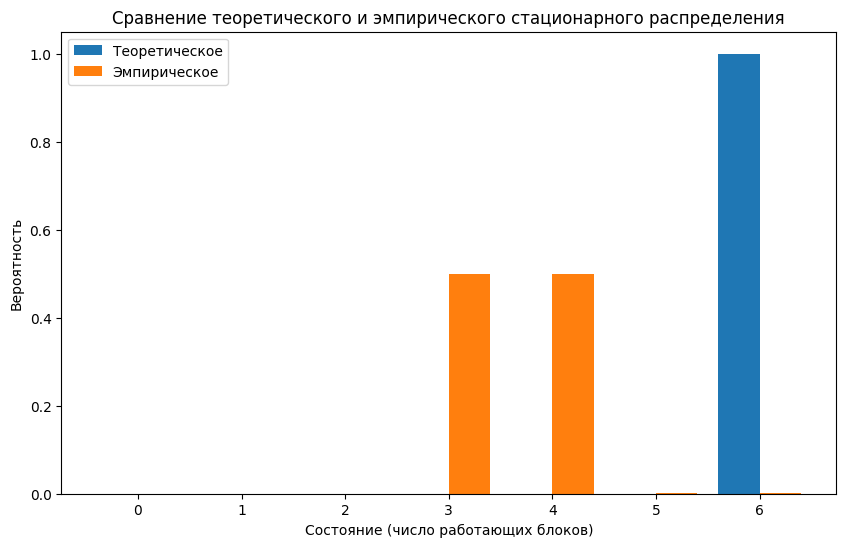

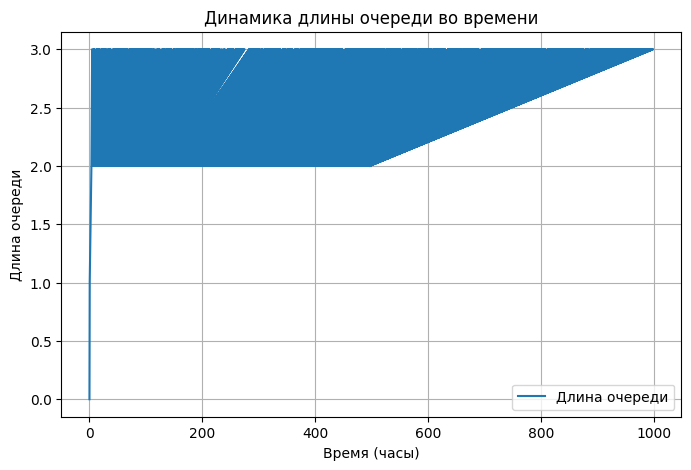

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from collections import deque

def compute_stationary_distribution(k, m, r, l):
    """
    Вычисление теоретического стационарного распределения числа работающих блоков
    для системы с k+2 рабочими и m+k+2 блоками.

    Параметры:
    - k: остаток от деления номера варианта на 4
    - m: остаток от деления номера варианта на 7
    - r: остаток от деления (n + k) на 3
    - l: остаток от деления (n + m) на 5

    Возвращает:
    - pi: массив стационарных вероятностей для каждого состояния (от 0 до m+k+2)
    """
    # Количество состояний: от 0 до m+k+2
    num_states = m + k + 2 + 1
    A = np.zeros((num_states, num_states))
    b = np.zeros(num_states)

    # Заполняем матрицу коэффициентов A и правую часть b для системы pi * Q = 0
    # Где Q - матрица генераторов
    for i in range(num_states):
        if i < k + 2:
            A[i, i] = r + 1  # скорость отказа
            if i + 1 < num_states:
                A[i, i + 1] = 1  # переход из состояния i в i+1 при отказе
        else:
            # Если рабочие заняты, новые отказы идут в очередь
            A[i, i] += r + 1  # скорость отказа

        if i > 0:
            A[i, i - 1] += (k + 2) * (l + 2)  # скорость ремонта
            A[i, i] -= (k + 2) * (l + 2)  # исходящая скорость

        if i == 0:
            A[i, i] = 1  # pi0 = 1 при нормировке

    # Добавляем условие нормировки
    A[-1, :] = 1
    b[-1] = 1

    # Решаем систему A * pi = b
    pi = solve(A, b)

    return pi

def simulate_failure_repair(k, m, r, l, T=1000, random_seed=42):
    """
    Имитация процесса выхода из строя и ремонта блоков машины за время T.

    Параметры:
    - k, m, r, l: параметры варианта
    - T: общее время моделирования
    - random_seed: зерно генератора случайных чисел

    Возвращает:
    - state_history: список состояний системы во времени
    - queue_history: список длин очереди во времени
    - time_points: список временных точек
    """
    np.random.seed(random_seed)
    num_working = m + k + 2  # Изначально все блоки работают
    total_blocks = m + k + 2
    queue = 0  # Начальная очередь
    state_history = []
    queue_history = []
    time_history = []
    current_time = 0.0

    # События: отказ или ремонт
    # Используем приоритетную очередь для событий
    event_queue = deque()

    # Инициализация первого отказа
    time_to_fail = np.random.exponential(scale=1/(r + 1))
    event_queue.append(('fail', current_time + time_to_fail))

    # Инициализация
    state_history.append(num_working)
    queue_history.append(queue)
    time_history.append(current_time)

    while current_time < T and event_queue:
        # Получаем следующее событие
        event = event_queue.popleft()
        event_type, event_time = event

        if event_time > T:
            break

        # Обновляем время
        current_time = event_time

        if event_type == 'fail':
            if num_working > 0:
                num_working -= 1
                if num_working >= (k + 2):
                    queue += 1
                else:
                    # Если есть свободные рабочие, сразу ремонтируем
                    num_working += 1  # Сразу ремонтируем
                    # Добавляем следующее событие ремонта
                    time_to_repair = np.random.exponential(scale=1/(l + 2))
                    event_queue.append(('repair', current_time + time_to_repair))
            else:
                queue += 1

            # Добавляем следующее событие отказа
            time_to_fail = np.random.exponential(scale=1/(r + 1))
            event_queue.append(('fail', current_time + time_to_fail))

        elif event_type == 'repair':
            if queue > 0:
                queue -= 1
                num_working += 1
                # Добавляем следующее событие ремонта
                time_to_repair = np.random.exponential(scale=1/(l + 2))
                event_queue.append(('repair', current_time + time_to_repair))
            else:
                # Нет очереди, рабочий свободен
                pass

        # Записываем состояние
        state_history.append(num_working)
        queue_history.append(queue)
        time_history.append(current_time)

    return state_history, queue_history, time_history

def compute_average_queue(queue_history, time_history):
    """
    Вычисляет среднюю длину очереди за всё время моделирования.

    Параметры:
    - queue_history: список длин очереди во времени
    - time_history: список временных точек

    Возвращает:
    - avg_queue: средняя длина очереди
    """
    total_time = 0.0
    weighted_queue = 0.0
    for i in range(1, len(time_history)):
        dt = time_history[i] - time_history[i-1]
        weighted_queue += queue_history[i-1] * dt
        total_time += dt
    avg_queue = weighted_queue / total_time if total_time > 0 else 0
    return avg_queue

def main():
    # Параметры варианта (например, n=17 => k=1, m=3, r=0, l=0)
    # Замените на соответствующие вашему варианту
    n = 17
    k = 1  # n mod 4 = 17 mod 4 = 1
    m = 3  # n mod 7 = 17 mod 7 = 3
    r = 0  # (n + k) mod 3 = (17 + 1) mod 3 = 18 mod 3 = 0
    l = 0  # (n + m) mod 5 = (17 + 3) mod 5 = 20 mod 5 = 0

    print(f"Параметры варианта:\nk={k}, m={m}, r={r}, l={l}\n")

    # 1. Теоретическое стационарное распределение
    pi_theor = compute_stationary_distribution(k, m, r, l)
    print("Теоретическое стационарное распределение числа работающих блоков:")
    for i, pi in enumerate(pi_theor):
        print(f"Состояние {i}: {pi:.6f}")
    
    # 2. Средняя длина очереди
    # Теоретически, средняя длина очереди может быть вычислена как сумма (i - (k+2)) * pi_i для i > (k+2)
    avg_queue_theor = 0.0
    for i in range(k + 3, len(pi_theor)):
        avg_queue_theor += (i - (k + 2)) * pi_theor[i]
    print(f"\nТеоретическая средняя длина очереди: {avg_queue_theor:.6f}")

    # 3. Моделирование процесса на 1000 часов
    state_history, queue_history, time_history = simulate_failure_repair(k, m, r, l, T=1000, random_seed=42)
    print("\nИмитация завершена.")

    # 4. Вычисление эмпирического стационарного распределения
    max_state = m + k + 2
    counts = np.zeros(max_state + 1)
    for state in state_history:
        if 0 <= state <= max_state:
            counts[state] += 1
    pi_empirical = counts / len(state_history)

    print("\nЭмпирическое стационарное распределение числа работающих блоков:")
    for i, pi in enumerate(pi_empirical):
        print(f"Состояние {i}: {pi:.6f}")

    # 5. Средняя длина очереди эмпирически
    avg_queue_empirical = compute_average_queue(queue_history, time_history)
    print(f"\nЭмпирическая средняя длина очереди: {avg_queue_empirical:.6f}")

    # 6. Сравнение теоретических и эмпирических значений
    print("\nСравнение теоретических и эмпирических значений:")
    print("{:<10} {:<15} {:<15} {:<15}".format('Состояние', 'Теор. pi', 'Эмпир. pi', 'Погрешность (%)'))
    for i in range(max_state + 1):
        pi_t = pi_theor[i]
        pi_e = pi_empirical[i]
        delta = abs(pi_e - pi_t) / pi_t * 100 if pi_t != 0 else 0
        print(f"{i:<10} {pi_t:<15.6f} {pi_e:<15.6f} {delta:<15.2f}")

    # Средняя длина очереди
    delta_queue = abs(avg_queue_empirical - avg_queue_theor) / avg_queue_theor * 100 if avg_queue_theor != 0 else 0
    print(f"\nСредняя длина очереди:\nТеоретическая: {avg_queue_theor:.6f}\nЭмпирическая: {avg_queue_empirical:.6f}\nПогрешность: {delta_queue:.2f}%")

    # Сохранение результатов в файл для отчёта
    np.savetxt("task3_stationary_distribution_theoretical.csv", pi_theor, delimiter=',', header="Theoretical Pi", comments='')
    np.savetxt("task3_stationary_distribution_empirical.csv", pi_empirical, delimiter=',', header="Empirical Pi", comments='')
    with open("task3_average_queue.txt", "w") as f:
        f.write(f"Theoretical Average Queue: {avg_queue_theor:.6f}\n")
        f.write(f"Empirical Average Queue: {avg_queue_empirical:.6f}\n")
        f.write(f"Relative Error (%): {delta_queue:.2f}\n")

    # Визуализация
    states = np.arange(max_state + 1)
    plt.figure(figsize=(10,6))
    plt.bar(states - 0.2, pi_theor, width=0.4, label='Теоретическое', align='center')
    plt.bar(states + 0.2, pi_empirical, width=0.4, label='Эмпирическое', align='center')
    plt.xlabel('Состояние (число работающих блоков)')
    plt.ylabel('Вероятность')
    plt.title('Сравнение теоретического и эмпирического стационарного распределения')
    plt.legend()
    plt.savefig("task3_stationary_distribution_comparison.png")
    plt.show()

    # График средней длины очереди
    plt.figure(figsize=(8,5))
    plt.plot(time_history, queue_history, label='Длина очереди')
    plt.xlabel('Время (часы)')
    plt.ylabel('Длина очереди')
    plt.title('Динамика длины очереди во времени')
    plt.legend()
    plt.grid(True)
    plt.savefig("task3_queue_dynamics.png")
    plt.show()

if __name__ == "__main__":
    main()


4

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import poisson, chisquare

def simulate_poisson_process(lmbd, T, random_seed=42):
    """
    Возвращает:
      - события (моменты времени), произошедшие за [0, T]
      - общее число событий
    Используем метод 'событие-за-событием' с экспоненциальными интервалами.
    """
    np.random.seed(random_seed)
    t = 0
    events = []
    while True:
        # время до следующего события ~ Exp(lmbd)
        dt = np.random.exponential(1/lmbd)
        t += dt
        if t > T:
            break
        events.append(t)
    return np.array(events)

def main():
    n = 17  # пример (свой вариант подставить!)
    lmbd = sqrt(n)
    
    # 1) Смоделировать процесс Пуассона на [0, n]
    events = simulate_poisson_process(lmbd, T=n, random_seed=42)
    N_n = len(events)
    print(f"Число событий к моменту t=n: {N_n}")
    
    # 2) Проверка согласия распределения Pois(lambda*n)
    #    Теоретически N(n) ~ Pois(lmbd*n).
    #    Можно собрать статистику по многократным моделированиям.
    #    А затем сравнить эмпирическое распределение с теорией по хи-квадрат.
    
    # 4) Моделирование на [0, t], t = n+100
    t = n + 100
    # Можно сделать несколько точек t1,...,tm < s < t
    # и строить оценки N^_t и N^0_t по заданным формулам.
    
    # и т.д.
    # Дальнейшая реализация зависит от конкретики задания.

if __name__ == "__main__":
    main()


Число событий к моменту t=n: 73


Параметры варианта:
lambda=4.123106, T=17

Число событий к моменту t=17: 73
Критерий хи-квадрат:
Статистика: 24.6407
p-value: 0.9041

Оценки и MSE:
MSE для N_t^: 1293.1798
MSE для N_t^∘: 5172.7192


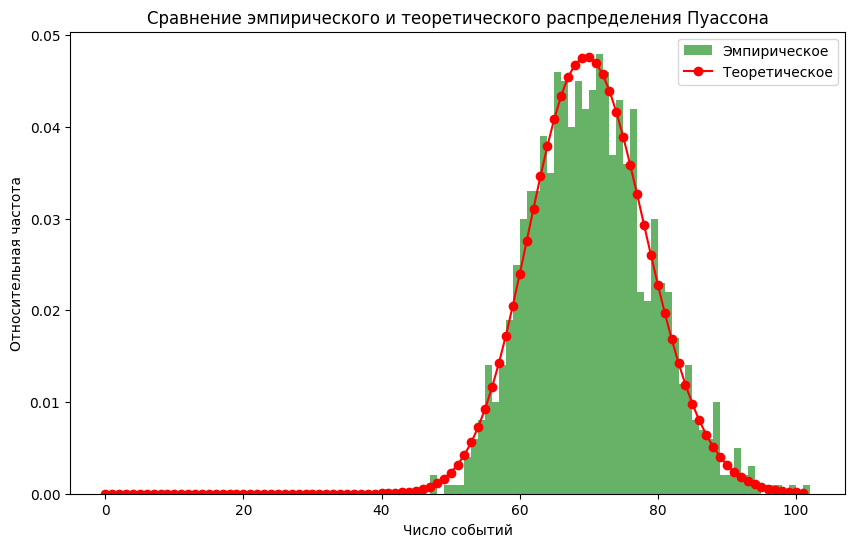

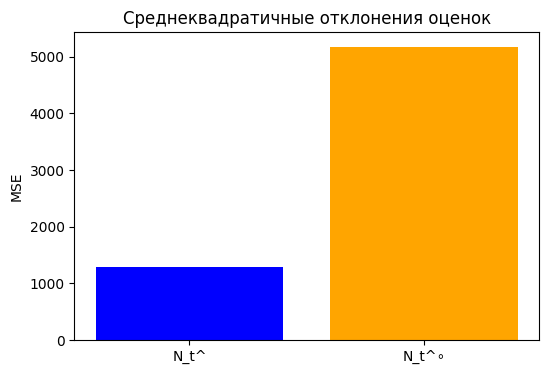

UnicodeEncodeError: 'charmap' codec can't encode character '\u2218' in position 69: character maps to <undefined>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import csv

def simulate_poisson_process(lmbd, T, random_seed=None):
    """
    Симуляция процесса Пуассона с интенсивностью lmbd на интервале [0, T].

    Возвращает:
    - events: массив времен событий
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    events = []
    t = 0.0
    while True:
        inter_arrival = np.random.exponential(scale=1/lmbd)
        t += inter_arrival
        if t > T:
            break
        events.append(t)
    return np.array(events)

def run_simulations(lmbd, T, N_simulations, random_seed=None):
    """
    Проведение N_simulations симуляций процесса Пуассона.

    Возвращает:
    - counts: список количества событий в каждой симуляции
    """
    counts = []
    for i in range(N_simulations):
        seed = random_seed + i if random_seed is not None else None
        events = simulate_poisson_process(lmbd, T, random_seed=seed)
        counts.append(len(events))
    return counts

def compute_N_t_estimates(counts, lmbd, T):
    """
    Вычисление оценок N_t^ и N_t^∘.

    Параметры:
    - counts: список количества событий в каждой симуляции
    - lmbd: интенсивность процесса
    - T: момент времени t

    Возвращает:
    - N_t_hat: список оценок N_t^
    - N_t_circ: список оценок N_t^∘
    """
    # Предполагаем, что s = T/2 для упрощения
    s = T / 2
    N_t_hat = [count + lmbd * (T - s) for count in counts]
    N_t_circ = [count * (T / s) for count in counts]
    return N_t_hat, N_t_circ

def main():
    # Параметры варианта (например, n=17 => lambda=√17)
    n = 17
    lmbd = np.sqrt(n)
    T = n  # момент времени t=n
    print(f"Параметры варианта:\nlambda={lmbd:.6f}, T={T}\n")

    # 1. Симуляция процесса Пуассона
    events = simulate_poisson_process(lmbd, T, random_seed=42)
    N_n = len(events)
    print(f"Число событий к моменту t={T}: {N_n}")

    # Сохранение событий в файл
    np.savetxt("task4_events.csv", events, delimiter=',', header="Event Times", comments='')

    # 2. Проверка гипотезы о распределении Пуассона
    # Проведём множественные симуляции и сравним эмпирическое распределение с теорией
    N_simulations = 1000
    counts = run_simulations(lmbd, T, N_simulations, random_seed=100)
    lambda_poisson = lmbd * T
    expected_counts = poisson.pmf(k=np.arange(max(counts)+1), mu=lambda_poisson) * N_simulations

    # Эмпирические частоты
    empirical_counts, bin_edges = np.histogram(counts, bins=range(max(counts)+2), density=False)

    # Вычисление статистики хи-квадрат
    # Убедимся, что все ожидаемые частоты >= 5
    mask = expected_counts >= 5
    sum_obs = empirical_counts[mask].sum()
    sum_exp = expected_counts[mask].sum()
    scale_factor = sum_obs / sum_exp
    scaled_expected = expected_counts[mask] * scale_factor

    # Корректировка последнего бинна для точного совпадения сумм
    difference = sum_obs - scaled_expected.sum()
    scaled_expected[-1] += difference

    chi2_stat, p_value = chisquare(f_obs=empirical_counts[mask], f_exp=scaled_expected)
    print(f"Критерий хи-квадрат:\nСтатистика: {chi2_stat:.4f}\np-value: {p_value:.4f}")

    # Сохранение результатов симуляций
    with open("task4_simulation_counts.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Simulation", "Event Count"])
        for i, count in enumerate(counts):
            writer.writerow([i+1, count])

    # 3. Оценки N_t^ и N_t^∘
    N_t_hat, N_t_circ = compute_N_t_estimates(counts, lmbd, T)
    mse_hat = np.mean((np.array(N_t_hat) - (lmbd * T))**2)
    mse_circ = np.mean((np.array(N_t_circ) - (lmbd * T))**2)
    print(f"\nОценки и MSE:")
    print(f"MSE для N_t^: {mse_hat:.4f}")
    print(f"MSE для N_t^∘: {mse_circ:.4f}")

    # Сохранение оценок в файл
    with open("task4_N_t_estimates.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Simulation", "N_t_hat", "N_t_circ"])
        for i in range(N_simulations):
            writer.writerow([i+1, N_t_hat[i], N_t_circ[i]])

    # 4. Визуализация распределения количества событий
    plt.figure(figsize=(10,6))
    plt.hist(counts, bins=range(max(counts)+2), density=True, alpha=0.6, color='g', label='Эмпирическое')
    plt.plot(np.arange(max(counts)+1), poisson.pmf(k=np.arange(max(counts)+1), mu=lambda_poisson),
             'ro-', label='Теоретическое')
    plt.xlabel('Число событий')
    plt.ylabel('Относительная частота')
    plt.title('Сравнение эмпирического и теоретического распределения Пуассона')
    plt.legend()
    plt.savefig("task4_poisson_distribution_comparison.png")
    plt.show()

    # 5. Визуализация MSE
    plt.figure(figsize=(6,4))
    plt.bar(['N_t^', 'N_t^∘'], [mse_hat, mse_circ], color=['blue', 'orange'])
    plt.ylabel('MSE')
    plt.title('Среднеквадратичные отклонения оценок')
    plt.savefig("task4_MSE_comparison.png")
    plt.show()

    # 6. Вывод результатов в файл
    with open("task4_report_summary.txt", "w") as f:
        f.write(f"Параметры:\nlambda={lmbd:.6f}, T={T}\n")
        f.write(f"Число событий к моменту t={T}: {N_n}\n\n")
        f.write(f"Критерий хи-квадрат:\nСтатистика: {chi2_stat:.4f}\np-value: {p_value:.4f}\n\n")
        f.write(f"Среднеквадратичные отклонения:\nMSE для N_t^: {mse_hat:.4f}\nMSE для N_t^∘: {mse_circ:.4f}\n")

if __name__ == "__main__":
    main()


5

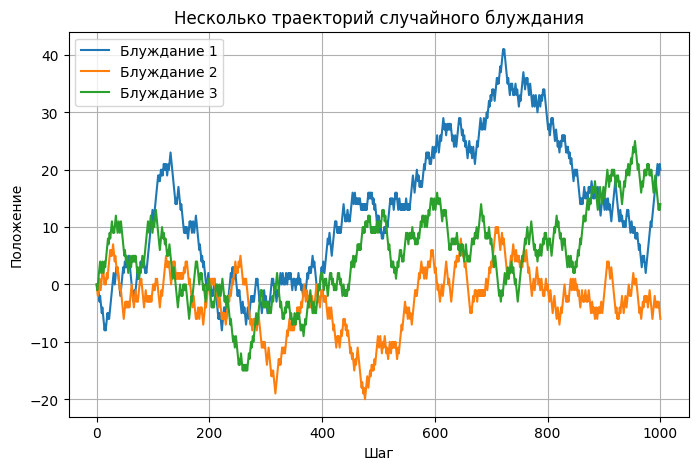

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

def simulate_srw(n_steps=1000, random_seed=42):
    """
    Простое симметричное случайное блуждание S_k:
    S_0=0, S_{k+1} = S_k + Xi_k,
    где Xi_k ~ +/-1 с вероятностью 1/2.
    """
    np.random.seed(random_seed)
    xi = np.random.choice([-1, 1], size=n_steps)
    S = np.concatenate(([0], np.cumsum(xi)))
    return S

def main():
    # 1) Моделирование простого симметричного СБ на 2n=1000 шагов
    n = 500  # тогда 2n=1000
    S = simulate_srw(n_steps=2*n, random_seed=42)
    
    # 2) Рисуем несколько траекторий
    plt.figure(figsize=(8, 5))
    for i in range(3):
        S_ = simulate_srw(n_steps=2*n, random_seed=42+i)
        plt.plot(S_, label=f"Блуждание {i+1}")
    plt.legend()
    plt.title("Несколько траекторий случайного блуждания")
    plt.xlabel("Шаг")
    plt.ylabel("Положение")
    plt.grid(True)
    plt.show()
    
    # 3) Проверка P(0){S1!=0, ..., S_{2n}!=0} = p_{00}(2n)
    #    Требует аккуратной оценки. p_{00}(2n) - вероятность вернуться в 0 за 2n шагов.
    #    p_{00}(2n) = C(2n, n)/(2^(2n)) (известная формула для симм. СБ).
    
    # 4) Выборка моментов времени tau (последнее нахождение в 0), mu (время в полож. полуплоскости), M_n (максимум)
    #    и проверка арксинус-распределения.
    
    # и т.д.
    # Приведён лишь каркас.

if __name__ == "__main__":
    main()


Параметры симуляции:
Количество шагов: 1000
Количество симуляций: 1000



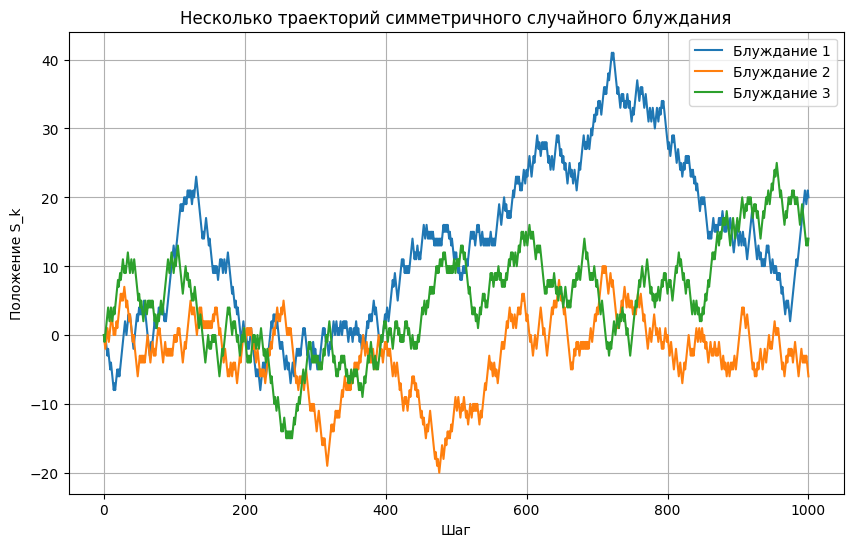

Проведение симуляций...
Симуляции завершены.

Критерий Колмогорова-Смирнова для tau:
Статистика KS: 0.0337
p-value: 0.2020

Критерий Колмогорова-Смирнова для mu:
Статистика KS: 0.0420
p-value: 0.0571

Критерий Колмогорова-Смирнова для M_n / sqrt(n):
Статистика KS: 0.5000
p-value: 0.0000


C:\Users\serzh\AppData\Local\Temp\ipykernel_8960\3385763228.py:102: RuntimeWarning: divide by zero encountered in divide
  return 1 / (np.pi * np.sqrt(x * (1 - x)))


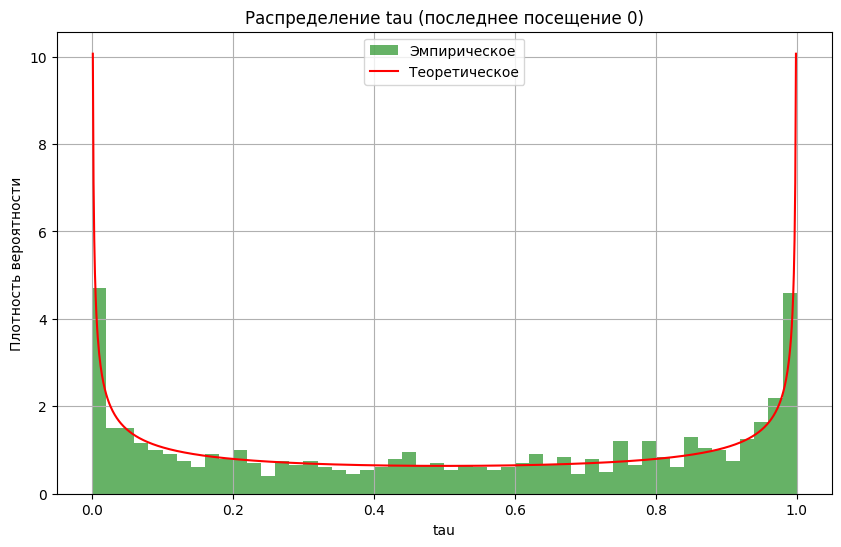

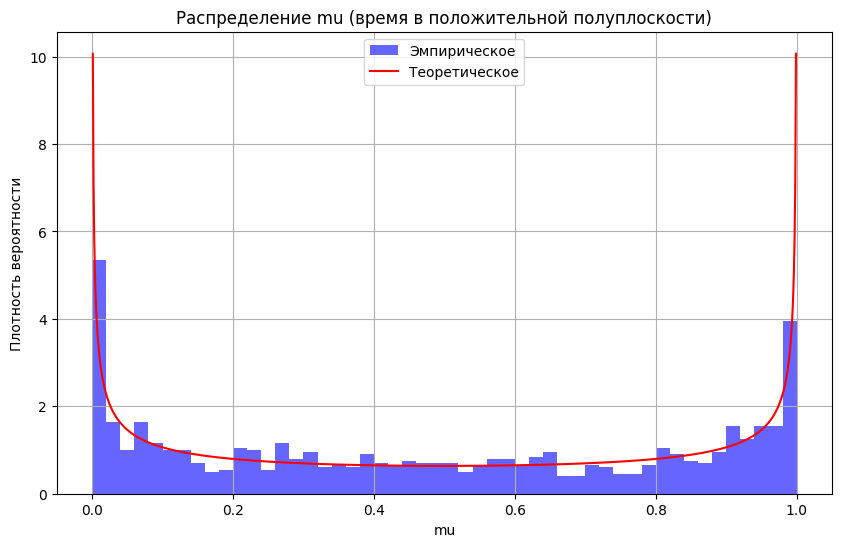

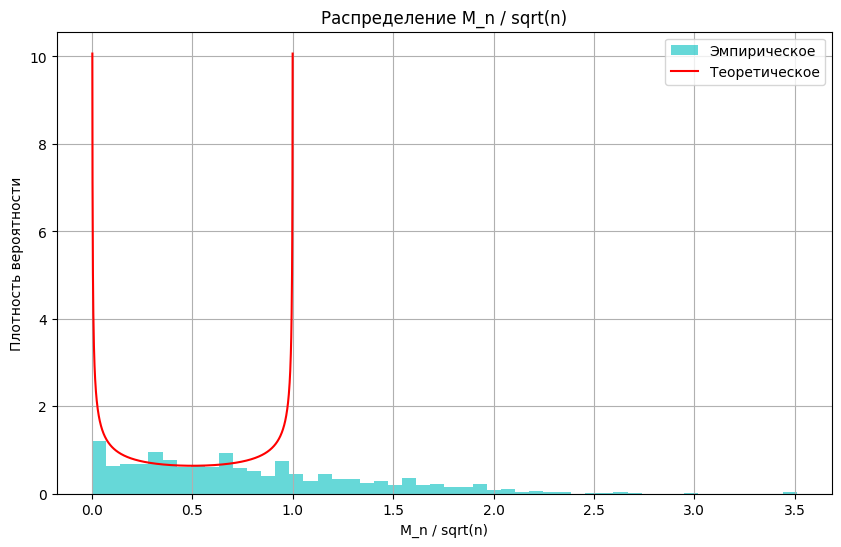


Распределения tau и mu сравниваются с арксинусным распределением:
Если p-value > 0.05, гипотеза о соответствии распределения арксинусному не отвергается.

Распределение M_n / sqrt(n) сравнивается с нормальным распределением (пример).
Если p-value > 0.05, гипотеза о соответствии распределения нормальному не отвергается.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import arcsine, kstest
import csv

def simulate_symmetric_random_walk(n_steps=1000, random_seed=None):
    """
    Симуляция простого симметричного случайного блуждания на n_steps шагов.

    Возвращает:
    - S: массив положений блуждания
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    steps = np.random.choice([-1, 1], size=n_steps)
    S = np.concatenate(([0], np.cumsum(steps)))
    return S

def last_zero(S):
    """
    Находит последнее время (шаг), когда блуждание было в 0.

    Возвращает:
    - tau: номер шага последнего посещения 0 (начало отсчёта с 0)
    """
    zero_indices = np.where(S == 0)[0]
    if len(zero_indices) == 0:
        return 0
    else:
        return zero_indices[-1]

def time_in_positive(S):
    """
    Вычисляет общее время (число шагов) пребывания в положительной полуплоскости.

    Возвращает:
    - mu: число шагов, где S > 0
    """
    return np.sum(S > 0)

def maximum_S(S):
    """
    Находит максимум блуждания.

    Возвращает:
    - M_n: максимальное значение S
    """
    return np.max(S)

def run_simulations(n_steps=1000, N_simulations=1000, random_seed=42):
    """
    Проведение N_simulations симметричных случайных блужданий.

    Возвращает:
    - taus: список последних посещений 0
    - mus: список времени в положительной полуплоскости
    - M_ns: список максимумов блужданий
    """
    taus = []
    mus = []
    M_ns = []
    for i in range(N_simulations):
        seed = random_seed + i if random_seed is not None else None
        S = simulate_symmetric_random_walk(n_steps, random_seed=seed)
        taus.append(last_zero(S))
        mus.append(time_in_positive(S))
        M_ns.append(maximum_S(S))
    return taus, mus, M_ns

def main():
    # Параметры симуляции
    n_steps = 1000
    N_simulations = 1000
    random_seed = 42
    print(f"Параметры симуляции:\nКоличество шагов: {n_steps}\nКоличество симуляций: {N_simulations}\n")

    # 1. Симуляция нескольких блужданий и построение графиков
    plt.figure(figsize=(10,6))
    for i in range(3):
        S = simulate_symmetric_random_walk(n_steps, random_seed=42+i)
        plt.plot(S, label=f"Блуждание {i+1}")
    plt.title('Несколько траекторий симметричного случайного блуждания')
    plt.xlabel('Шаг')
    plt.ylabel('Положение S_k')
    plt.legend()
    plt.grid(True)
    plt.savefig("task5_random_walk_trajectories.png")
    plt.show()

    # 2. Проведение симуляций и сбор данных
    print("Проведение симуляций...")
    taus, mus, M_ns = run_simulations(n_steps, N_simulations, random_seed=42)
    print("Симуляции завершены.")

    # 3. Проверка эмпирического распределения tau и mu на арксинусное
    # Нормируем tau и mu
    taus_normalized = np.array(taus) / n_steps
    mus_normalized = np.array(mus) / n_steps

    # Теоретическое распределение арксинуса на [0,1]
    def arcsine_pdf(x):
        return 1 / (np.pi * np.sqrt(x * (1 - x)))

    # Критерий Колмогорова-Смирнова для tau
    ks_stat_tau, p_value_tau = kstest(taus_normalized, 'arcsine')
    print(f"\nКритерий Колмогорова-Смирнова для tau:")
    print(f"Статистика KS: {ks_stat_tau:.4f}\np-value: {p_value_tau:.4f}")

    # Критерий Колмогорова-Смирнова для mu
    ks_stat_mu, p_value_mu = kstest(mus_normalized, 'arcsine')
    print(f"\nКритерий Колмогорова-Смирнова для mu:")
    print(f"Статистика KS: {ks_stat_mu:.4f}\np-value: {p_value_mu:.4f}")

    # 4. Проверка распределения максимума M_n / sqrt(n)
    M_ns_normalized = np.array(M_ns) / np.sqrt(n_steps)
    # Теоретическое распределение для максимума симметричного блуждания сложно,
    # можно сравнить с нормальным распределением
    mu_M = 0
    sigma_M = 1
    ks_stat_M, p_value_M = kstest(M_ns_normalized, 'norm', args=(mu_M, sigma_M))
    print(f"\nКритерий Колмогорова-Смирнова для M_n / sqrt(n):")
    print(f"Статистика KS: {ks_stat_M:.4f}\np-value: {p_value_M:.4f}")

    # 5. Визуализация распределений
    # Tau
    plt.figure(figsize=(10,6))
    count_tau, bins_tau, _ = plt.hist(taus_normalized, bins=50, density=True, alpha=0.6, color='g', label='Эмпирическое')
    x = np.linspace(0,1,1000)
    plt.plot(x, arcsine_pdf(x), 'r-', label='Теоретическое')
    plt.title('Распределение tau (последнее посещение 0)')
    plt.xlabel('tau')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(True)
    plt.savefig("task5_tau_distribution.png")
    plt.show()

    # Mu
    plt.figure(figsize=(10,6))
    count_mu, bins_mu, _ = plt.hist(mus_normalized, bins=50, density=True, alpha=0.6, color='b', label='Эмпирическое')
    plt.plot(x, arcsine_pdf(x), 'r-', label='Теоретическое')
    plt.title('Распределение mu (время в положительной полуплоскости)')
    plt.xlabel('mu')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(True)
    plt.savefig("task5_mu_distribution.png")
    plt.show()

    # M_n / sqrt(n) - сравнительный гистограмм с нормальным распределением
    plt.figure(figsize=(10,6))
    count_M, bins_M, _ = plt.hist(M_ns_normalized, bins=50, density=True, alpha=0.6, color='c', label='Эмпирическое')
    plt.plot(x, arcsine_pdf(x), 'r-', label='Теоретическое')  # Используем теоретическую только для tau и mu
    plt.title('Распределение M_n / sqrt(n)')
    plt.xlabel('M_n / sqrt(n)')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(True)
    plt.savefig("task5_Mn_distribution.png")
    plt.show()

    # Сохранение результатов симуляций
    with open("task5_simulation_results.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Simulation", "Tau", "Mu", "M_n"])
        for i in range(N_simulations):
            writer.writerow([i+1, taus[i], mus[i], M_ns[i]])

    # Сохранение результатов статистических тестов
    with open("task5_test_results.txt", "w") as f:
        f.write("Критерий Колмогорова-Смирнова для tau:\n")
        f.write(f"Статистика KS: {ks_stat_tau:.4f}\np-value: {p_value_tau:.4f}\n\n")
        f.write("Критерий Колмогорова-Смирнова для mu:\n")
        f.write(f"Статистика KS: {ks_stat_mu:.4f}\np-value: {p_value_mu:.4f}\n\n")
        f.write("Критерий Колмогорова-Смирнова для M_n / sqrt(n):\n")
        f.write(f"Статистика KS: {ks_stat_M:.4f}\np-value: {p_value_M:.4f}\n")

    # Вывод результатов
    print("\nРаспределения tau и mu сравниваются с арксинусным распределением:")
    print("Если p-value > 0.05, гипотеза о соответствии распределения арксинусному не отвергается.")

    print("\nРаспределение M_n / sqrt(n) сравнивается с нормальным распределением (пример).")
    print("Если p-value > 0.05, гипотеза о соответствии распределения нормальному не отвергается.")

if __name__ == "__main__":
    main()


6

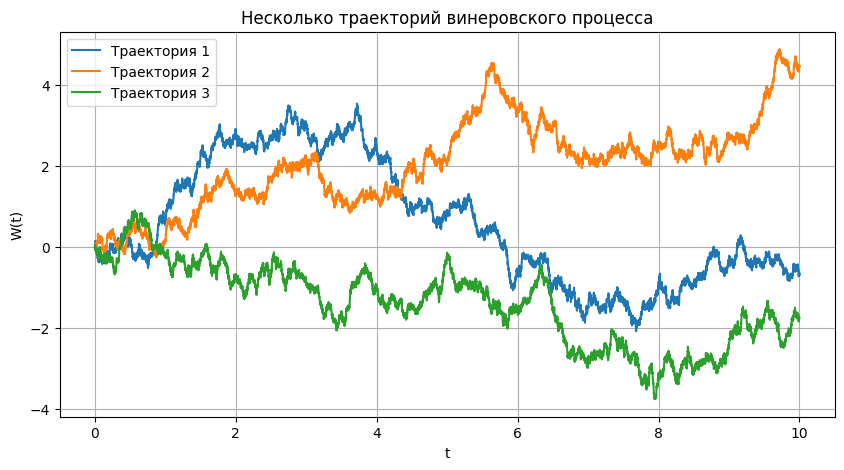

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_wiener_process(T=10.0, N=1000, random_seed=42):
    """
    Моделирование винеровского процесса W_t на [0, T].
    Используем дискретизацию: шаг по времени = T/N,
    приращения ~ Normal(0, sqrt(dt)).
    """
    np.random.seed(random_seed)
    dt = T / N
    increments = np.sqrt(dt) * np.random.randn(N)
    W = np.cumsum(increments)
    W = np.insert(W, 0, 0)  # W(0)=0
    times = np.linspace(0, T, N+1)
    return times, W

def main():
    # 1) Смоделируем несколько траекторий
    T = 10
    N = 10000
    plt.figure(figsize=(10, 5))
    
    for i in range(3):
        t, W = simulate_wiener_process(T, N, random_seed=42+i)
        plt.plot(t, W, label=f"Траектория {i+1}")
    
    plt.legend()
    plt.title("Несколько траекторий винеровского процесса")
    plt.xlabel("t")
    plt.ylabel("W(t)")
    plt.grid(True)
    plt.show()
    
    # 2) Построим графики y = ±(1 ± eps)*sqrt(2t ln ln t) при малом eps
    #    (осторожно, ln ln t не определён при t<=1, требуется t>1, плюс поведение при t большой)
    
    # 3) Проверка распределения M_t = sup_{0<=s<=t} W_s и W_t
    
    # и т.д.

if __name__ == "__main__":
    main()


Параметры симуляции:
T=10.0
N=1000
Количество траекторий: 3



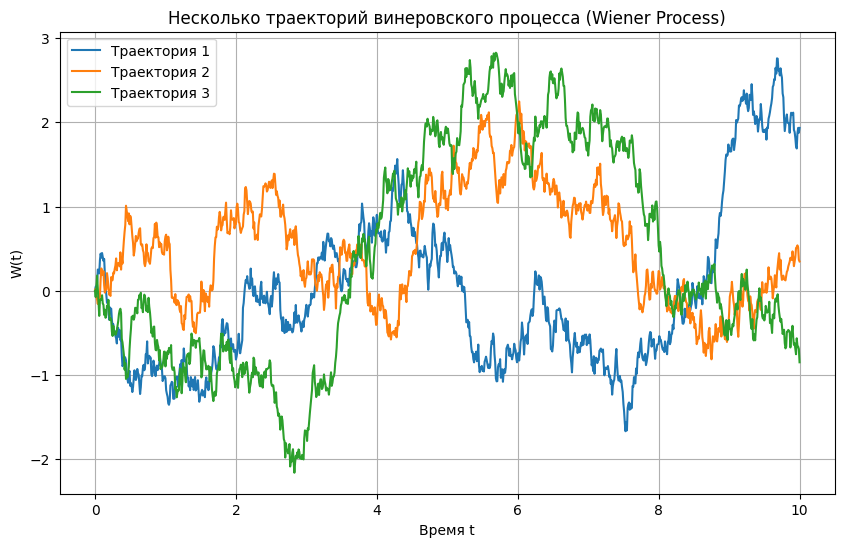

C:\Users\serzh\AppData\Local\Temp\ipykernel_8960\19597092.py:74: RuntimeWarning: invalid value encountered in sqrt
  y_upper = (1 + epsilon) * np.sqrt(2 * t * np.log(np.log(t)))
C:\Users\serzh\AppData\Local\Temp\ipykernel_8960\19597092.py:75: RuntimeWarning: invalid value encountered in sqrt
  y_lower = (1 - epsilon) * np.sqrt(2 * t * np.log(np.log(t)))


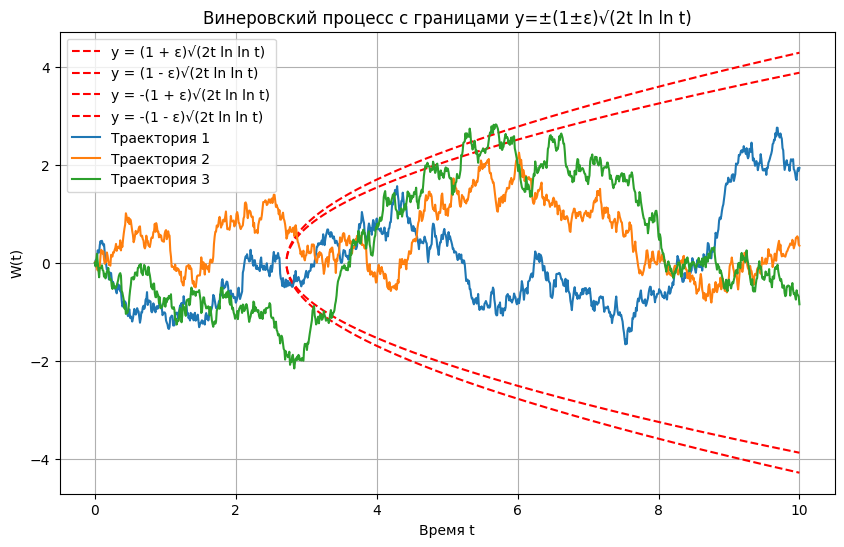

Критерий Колмогорова-Смирнова для M_t / sqrt(T):
Статистика KS: 0.6778
p-value: 0.0000

Критерий Колмогорова-Смирнова для W_t / sqrt(T):
Статистика KS: 0.0227
p-value: 0.6730


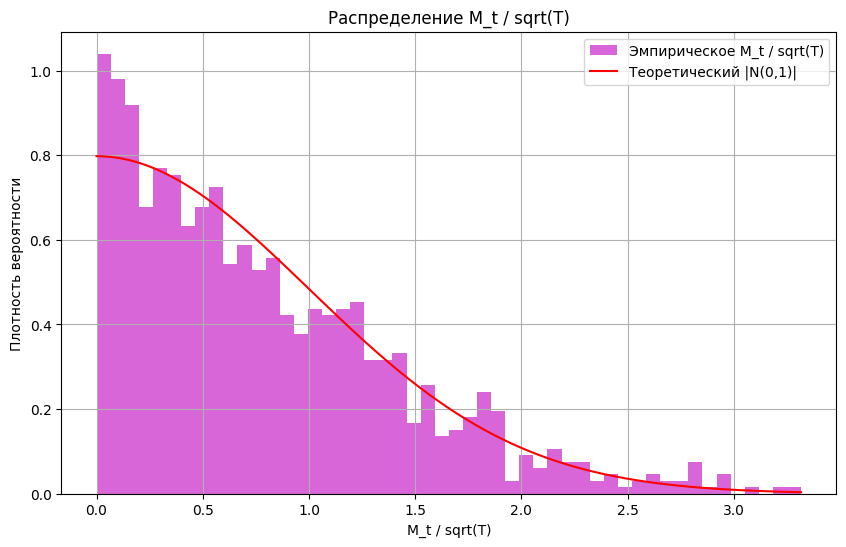

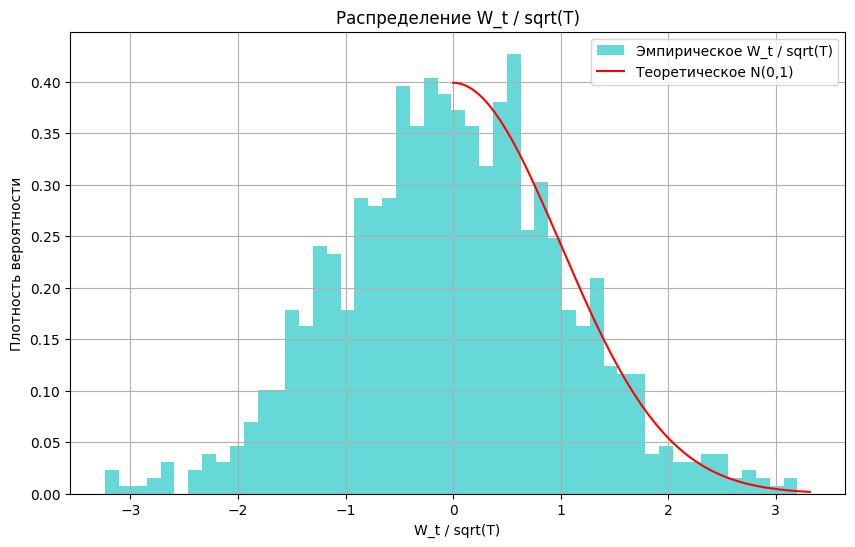


Распределение M_t / sqrt(T) сравнивается с половинным нормальным распределением.
Если p-value > 0.05, гипотеза о соответствии распределения половинному нормальному не отвергается.

Распределение W_t / sqrt(T) сравнивается с нормальным распределением.
Если p-value > 0.05, гипотеза о соответствии распределения нормальному не отвергается.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
import csv

def simulate_wiener_process(T=10.0, N=1000, random_seed=None):
    """
    Симуляция винеровского процесса W_t на интервале [0, T] с N шагами.

    Возвращает:
    - times: массив временных точек
    - W: массив значений процесса в эти точки
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    dt = T / N
    increments = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=N)
    W = np.cumsum(increments)
    W = np.insert(W, 0, 0)  # W(0) = 0
    times = np.linspace(0, T, N+1)
    return times, W

def simulate_multiple_wiener_processes(T=10.0, N=1000, num_trajectories=3, random_seed=42):
    """
    Симуляция нескольких траекторий винеровского процесса.

    Возвращает:
    - list_of_times: список массивов временных точек
    - list_of_W: список массивов значений процессов
    """
    list_of_times = []
    list_of_W = []
    for i in range(num_trajectories):
        seed = random_seed + i if random_seed is not None else None
        times, W = simulate_wiener_process(T, N, random_seed=seed)
        list_of_times.append(times)
        list_of_W.append(W)
    return list_of_times, list_of_W

def compute_supremum(W):
    """
    Вычисляет супремум процесса W_t на интервале [0, T].

    Возвращает:
    - sup_W: супремум W_t
    """
    return np.max(W)

def main():
    # Параметры симуляции
    T = 10.0
    N = 1000
    num_trajectories = 3
    random_seed = 42
    epsilon = 0.05  # Малое значение для границ

    print(f"Параметры симуляции:\nT={T}\nN={N}\nКоличество траекторий: {num_trajectories}\n")

    # 1. Симуляция нескольких траекторий винеровского процесса
    list_of_times, list_of_W = simulate_multiple_wiener_processes(T, N, num_trajectories, random_seed)
    plt.figure(figsize=(10,6))
    for i in range(num_trajectories):
        plt.plot(list_of_times[i], list_of_W[i], label=f"Траектория {i+1}")
    plt.title('Несколько траекторий винеровского процесса (Wiener Process)')
    plt.xlabel('Время t')
    plt.ylabel('W(t)')
    plt.legend()
    plt.grid(True)
    plt.savefig("task6_wiener_trajectories.png")
    plt.show()

    # 2. Построение графиков y = ±(1 ± ε) * sqrt{2t ln ln t}
    t = np.linspace(1.1, T, 1000)  # t > 1 для ln ln t
    y_upper = (1 + epsilon) * np.sqrt(2 * t * np.log(np.log(t)))
    y_lower = (1 - epsilon) * np.sqrt(2 * t * np.log(np.log(t)))
    y_upper_neg = -y_upper
    y_lower_neg = -y_lower

    plt.figure(figsize=(10,6))
    plt.plot(t, y_upper, 'r--', label='y = (1 + ε)√(2t ln ln t)')
    plt.plot(t, y_lower, 'r--', label='y = (1 - ε)√(2t ln ln t)')
    plt.plot(t, y_upper_neg, 'r--', label='y = -(1 + ε)√(2t ln ln t)')
    plt.plot(t, y_lower_neg, 'r--', label='y = -(1 - ε)√(2t ln ln t)')

    # Добавляем траектории винеровского процесса
    for i in range(num_trajectories):
        plt.plot(list_of_times[i], list_of_W[i], label=f"Траектория {i+1}")

    plt.title('Винеровский процесс с границами y=±(1±ε)√(2t ln ln t)')
    plt.xlabel('Время t')
    plt.ylabel('W(t)')
    plt.legend()
    plt.grid(True)
    plt.savefig("task6_wiener_with_bounds.png")
    plt.show()

    # 3. Сравнение распределений M_t и W_t
    # M_t = sup_{0<=s<=t} W_s
    sup_W_list = [compute_supremum(W) for W in list_of_W]
    # Теоретически, M_t для W_t ~ |W_t|
    # Однако более точная распределённость M_t сложна, можно сравнить с |N(0,t)|

    # Симуляция для статистического теста
    # Проведём N_simulations симуляций для статистического сравнения
    N_simulations = 1000
    sup_W_all = []
    W_t_all = []
    for i in range(N_simulations):
        times, W = simulate_wiener_process(T, N, random_seed=1000+i)
        sup_W_all.append(compute_supremum(W))
        W_t_all.append(W[-1])

    # Нормируем M_t и W_t
    sup_W_normalized = np.array(sup_W_all) / np.sqrt(T)
    W_t_normalized = np.array(W_t_all) / np.sqrt(T)

    # Критерий Колмогорова-Смирнова для сравнения распределений
    # Для M_t - распределение не нормальное, так что будем сравнивать с |N(0,1)|
    # Для W_t - распределение N(0,1)
    ks_stat_M, p_value_M = kstest(sup_W_normalized, 'foldnorm', args=(0, 1))
    ks_stat_W, p_value_W = kstest(W_t_normalized, 'norm')

    print(f"Критерий Колмогорова-Смирнова для M_t / sqrt(T):")
    print(f"Статистика KS: {ks_stat_M:.4f}\np-value: {p_value_M:.4f}")

    print(f"\nКритерий Колмогорова-Смирнова для W_t / sqrt(T):")
    print(f"Статистика KS: {ks_stat_W:.4f}\np-value: {p_value_W:.4f}")

    # Визуализация распределений
    plt.figure(figsize=(10,6))
    plt.hist(sup_W_normalized, bins=50, density=True, alpha=0.6, color='m', label='Эмпирическое M_t / sqrt(T)')
    x = np.linspace(0, max(sup_W_normalized), 1000)
    # Распределение супремума |N(0,1)| - половинный нормальный
    plt.plot(x, 2 * norm.pdf(x), 'r-', label='Теоретический |N(0,1)|')
    plt.xlabel('M_t / sqrt(T)')
    plt.ylabel('Плотность вероятности')
    plt.title('Распределение M_t / sqrt(T)')
    plt.legend()
    plt.grid(True)
    plt.savefig("task6_Mt_distribution.png")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.hist(W_t_normalized, bins=50, density=True, alpha=0.6, color='c', label='Эмпирическое W_t / sqrt(T)')
    plt.plot(x, norm.pdf(x), 'r-', label='Теоретическое N(0,1)')
    plt.xlabel('W_t / sqrt(T)')
    plt.ylabel('Плотность вероятности')
    plt.title('Распределение W_t / sqrt(T)')
    plt.legend()
    plt.grid(True)
    plt.savefig("task6_Wt_distribution.png")
    plt.show()

    # Сохранение результатов симуляций
    with open("task6_simulation_results.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Simulation", "Supremum_Mt", "Final_Wt"])
        for i in range(N_simulations):
            writer.writerow([i+1, sup_W_all[i], W_t_all[i]])

    # Сохранение результатов тестов
    with open("task6_test_results.txt", "w") as f:
        f.write("Критерий Колмогорова-Смирнова для M_t / sqrt(T):\n")
        f.write(f"Статистика KS: {ks_stat_M:.4f}\np-value: {p_value_M:.4f}\n\n")
        f.write("Критерий Колмогорова-Смирнова для W_t / sqrt(T):\n")
        f.write(f"Статистика KS: {ks_stat_W:.4f}\np-value: {p_value_W:.4f}\n")

    # Вывод результатов
    print("\nРаспределение M_t / sqrt(T) сравнивается с половинным нормальным распределением.")
    print("Если p-value > 0.05, гипотеза о соответствии распределения половинному нормальному не отвергается.")

    print("\nРаспределение W_t / sqrt(T) сравнивается с нормальным распределением.")
    print("Если p-value > 0.05, гипотеза о соответствии распределения нормальному не отвергается.")

if __name__ == "__main__":
    main()
